In [1]:
import numpy as np
from scipy.io import loadmat

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('seaborn-notebook')
%matplotlib inline

In [2]:
def show_quantization(X, X_c, ax=None):
    p, q = X.shape[0], X_c.shape[0]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    ax.scatter(X[:,0], X[:,1], c='black', alpha=0.4, s=10, marker='.')
    ax.scatter(X_c[:,0], X_c[:,1], c='m', alpha=0.8, s=50, marker='o')
    ax.set(title=f"Vector quantization ({p} samples - {q} centroids)", xlabel="$X_1$", ylabel="$X_2$")

# Models

In [3]:
def distance(z, p):
    return np.sqrt(((z - p)**2).sum(1))

def assign_centroids(X, X_c, centroid_weights=1):
    return np.apply_along_axis(lambda x: np.argmin(distance(x, X_c) * centroid_weights), 1, X)

def adaptation_rule(X, ix, X_c, α):
    n = X.shape[0]
    
    for i in np.random.choice(n, n, replace=False):
        j = ix[i]
        X_c[j] = X_c[j] + α * (X[i] - X_c[j])
        
def assignment_error(X, ix, X_c):
    return np.mean(np.sqrt((X - X_c[ix])**2).sum(1))

In [4]:
def wta_learning(X, nb_centroids=4, total_steps=20, α=.9, β=1, method='competitive'):
    n = X.shape[0]
    X_c = X[np.random.choice(n, size=nb_centroids, replace=False), :]
    
    centroid_weights = np.ones(nb_centroids)
    for i in range(total_steps):
        # Assignment
        ix = assign_centroids(X, X_c, centroid_weights)
        if method == 'fsl':
            centroid_weights += np.asarray([np.sum(ix == z) for z in range(nb_centroids)])
        
        # Adaptation rule
        adaptation_rule(X, ix, X_c, α)
        
        # Decrease α
        α = α * β / (α+β)

    print(f"α={α:.3f}, E={assignment_error(X, ix, X_c):.3f}")    
    return X_c

In [5]:
def neural_gas_learning(X, nb_centroids=4, total_steps=20, α=.9, β=1, λ=.1):
    n = X.shape[0]
    X_c = X[np.random.choice(n, size=nb_centroids, replace=False), :]
    
    for i in range(total_steps):
        # Ranking
        ranks = np.apply_along_axis(lambda x: np.argsort(distance(x, X_c)), 1, X)
        
        # Adaptation rule
        for i in np.random.choice(n, n, replace=False):
            for j in range(nb_centroids):
                X_c[j] = X_c[j] + α * np.exp(-ranks[i,j] / λ) * (X[i] - X_c[j])
    
        # Decrease α
        α = α * β / (α+β)
        
    print(f"α={α:.3f}, E={assignment_error(X, assign_centroids(X, X_c), X_c):.3f}")    
    return X_c

# Validation on empirical data

In [6]:
X = loadmat('dataset_1.mat')['X']

In [7]:
print("Competitive")
X_c1 = wta_learning(X, nb_centroids=2, method='competitive')

print("\nFSL")
X_c2 = wta_learning(X, nb_centroids=2, method='fsl')

print("\nNeural gas")
X_c3 = neural_gas_learning(X, nb_centroids=2)

Competitive
α=0.047, E=0.728

FSL
α=0.047, E=0.603

Neural gas
α=0.047, E=0.610


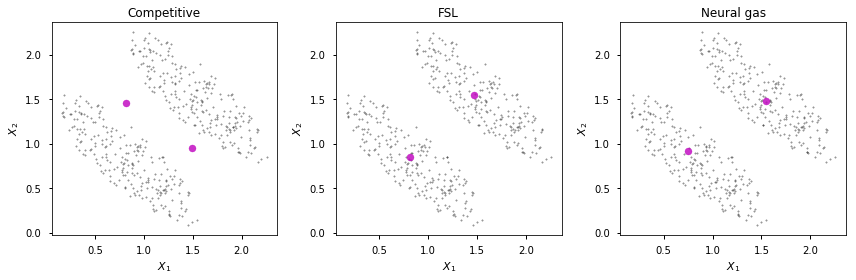

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

show_quantization(X, X_c1, ax=axes[0]); axes[0].set_title('Competitive')
show_quantization(X, X_c2, ax=axes[1]); axes[1].set_title('FSL')
show_quantization(X, X_c3, ax=axes[2]); axes[2].set_title('Neural gas')

fig.tight_layout()

In [9]:
X = loadmat('dataset_3.mat')['X']

In [10]:
print("Competitive")
X_c1 = wta_learning(X, nb_centroids=2, method='competitive')

print("\nFSL")
X_c2 = wta_learning(X, nb_centroids=2, method='fsl')

print("\nNeural gas")
X_c3 = neural_gas_learning(X, nb_centroids=2)

Competitive
α=0.047, E=0.544

FSL
α=0.047, E=0.585

Neural gas
α=0.047, E=0.552


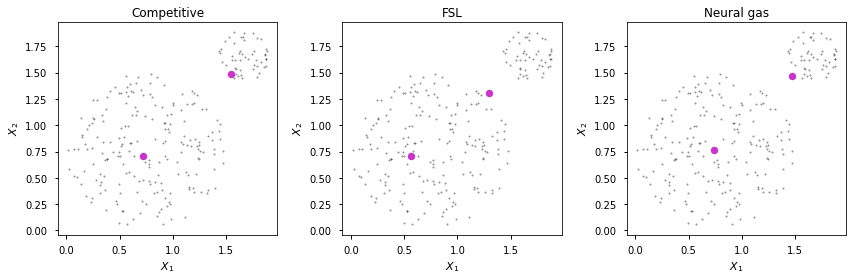

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

show_quantization(X, X_c1, ax=axes[0]); axes[0].set_title('Competitive')
show_quantization(X, X_c2, ax=axes[1]); axes[1].set_title('FSL')
show_quantization(X, X_c3, ax=axes[2]); axes[2].set_title('Neural gas')

fig.tight_layout()